Author: SRISAICHARAN VELISETTI

In [1]:
## Import necessary libraries here (You can add libraries you want to use here)
import cv2  
import numpy as np
from scipy.io import loadmat
from scipy import ndimage
from scipy.signal import order_filter 
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import cv2 as cv
import scipy.ndimage.filters as nd_filters
import time

%matplotlib inline

#  A Feature Tracker 

## Overview

In the problem, you will implement a corner detector and feature tracker that track features from the image sequence hotel. Since this is a two part problem, we have included precomputed intermediate results in the *Data* section in case you’re unable to complete any portion.

<img src="https://drive.google.com/uc?id=1sBtKpU2mYEPZ9c2Cvw-DBuLBPK2gYwC-" width="700"/>

**Note:**  Do not use existing keypoint
detectors, trackers, or structure from motion code, such as found on the web, and OpenCV.

## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 1fT0H-FbbDZnjMfCJHZcscpcwAXHhGgNw
!unzip "/content/part1_images.zip" -d "/content/"
!gdown 1r-Pdino6MRLCEWX_sQOgd8D5AVsRc7Ym
# Load Initial Key Points
data = loadmat('/content/initial_keypoints.mat')
X0 = data['Xo']
Y0 = data['Yo']

## Helper Functions

In [3]:
def readImages(folder, num_images):
  arr_images = []
  for i in range(num_images):
    arr_images.append(cv2.imread(f'{folder}hotel.seq{i}.png'))
  return np.array(arr_images, dtype=np.float32)

def trackPoints(pt_x, pt_y, im, ws):
  '''
  Tracking initial points (pt_x, pt_y) across the image sequence
  Outputs:
    track_x: [Number of keypoints] x [2]
    track_y: [Number of keypoints] x [2]
  '''
  N = np.prod(pt_x.shape)
  nim = len(im)
  track_x = np.zeros((N, nim))
  track_y = np.zeros((N, nim))
  track_x[:,0] = pt_x
  track_y[:,0] = pt_y

  for t in range(nim-1):
    track_x[:, t+1], track_y[:, t+1] = getNextPoints(track_x[:, t], track_y[:, t], im[t,:,:], im[t+1,:,:], ws)
  return track_x, track_y

# read all 51 sequences of images
folder = '/content/part1_images/'
im = readImages(folder, 51) 

## 1.1 Keypoint Selection  
For the first frame, use the second moment matrix to locate strong corners to use as keypoints.
These points will be tracked throughout the sequence in the second part of the problem. Choose a proper threshold so that edges and noisy patches are ignored. Do local non-maxima suppression over a 5x5 window centered at each point.
This should give several hundred good points to track.

### Code 

Number of Corners Detected: 701


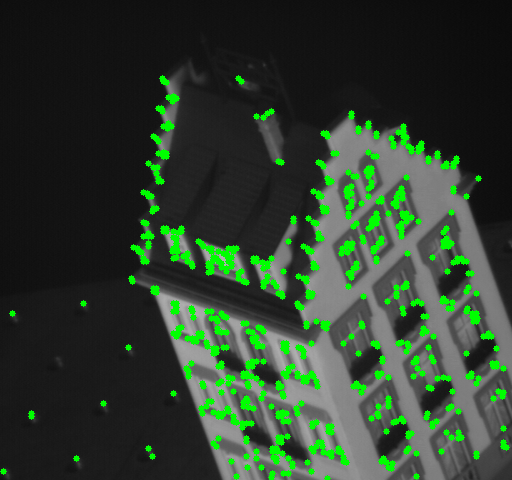

In [4]:
def getKeypoints(img, tau):
  '''
  Detecting keypoints using Harris corner criterion
  img: input image
  tau: threshold 
  
  output: (N,2) array of [x,y] keypoints
  '''
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.GaussianBlur(img, (5, 5), 1).astype('float32')
  height, width = img.shape[0],img.shape[1]
  R = np.zeros((height,width))
  sobel_x = np.array(([-1,0,1],[-2,0,2],[-1,0,1]))
  sobel_y = sobel_x.T
  ix =  cv2.filter2D(img,-1,sobel_x) 
  iy =  cv2.filter2D(img,-1,sobel_y)
  
  Ixx = np.power(ix,2)
  Iyy = np.power(iy,2)
  Ixy = ix*iy

  kernel2 = np.ones((3, 3), np.float32)/25
  kernel2 = np.array((
    [1/16, 2/16, 1/16],
    [2/16, 4/16, 2/16],
    [1/16, 2/16, 1/16]), dtype="float64")

  Ixx = cv2.filter2D(np.power(ix,2), -1, kernel2)
  Iyy = cv2.filter2D(np.power(iy,2), -1, kernel2)
  Ixy = cv2.filter2D(ix*iy, -1, kernel2)

  window_size = 3
  offset = int( window_size / 2 )

  for y in range(offset, height-offset):
        for x in range(offset, width-offset):
            Sx2 = np.sum(Ixx[y-offset:y+1+offset, x-offset:x+1+offset]) 
            Sy2 = np.sum(Iyy[y-offset:y+1+offset, x-offset:x+1+offset])
            Sxy = np.sum(Ixy[y-offset:y+1+offset, x-offset:x+1+offset])
            H = np.array([[Sx2,Sxy],[Sxy,Sy2]]) 
            det = np.linalg.det(H)
            tr = np.matrix.trace(H)
            R[y-offset, x-offset] = det / tr 
  cv2.normalize(R, R, 0, 1, cv2.NORM_MINMAX)
  cornerList = []

  #NMS
  for y in range(offset, height-offset,5):
        for x in range(offset, width-offset,5):
            value=R[y-offset:y+1+offset, x-offset:x+1+offset]
            _, max_v, _, max_loc = cv2.minMaxLoc(value)
            if max_v>tau:
                cornerList.append([x+max_loc[0], y+max_loc[1]])
  return np.array(cornerList)


tau = 0.07
key_pts = getKeypoints(im[0], tau)
print('Number of Corners Detected:', key_pts.shape[0])
img_cpy = im[0].copy()


for x,y in key_pts:
  cv2.circle(img_cpy,(x,y),3,(0,255,0),-1)
result_keypoints = img_cpy 
cv2_imshow(result_keypoints)


Args : 
- img - input image. 
- tau - threshold for the Non-maximum supression.

Output:  
- x,y Keypoints detected of shape [Nx2].

Initially, the image is converted to a gray-scale image (3 channel to 1) and gaussian blur (optional to reduce the noise) is applied to get a smoothened image. Secondly, the derivate of gaussian along x and y directions are computed using sobel filter and also, weighted average filtered Ixx,Ixy,Iyy are calculated. For a user-defined window size, the harris corner score is computed on the overall image by sliding window method. Finally, non-maximum supression is applied to the over-all harris corners score where the maximum value, that is greater then the threshold(tau), is selected over the window size of 15x15 and an indics of the keypoints detected is returned in an array.

## 1.2 Feature Tracking 

Applying the Kanade-Lucas-Tomasi tracking procedure to track the keypoints found in part 1.1 (or the given keypoints in the *Data* section) throughout the hotel sequence. 

<img src="https://drive.google.com/uc?id=1dU4p4YcnXoQFnrNvleEty_4tDECkVW9Q" width="500"/>

Some keypoints will move out of the image frame over the course of the sequence. Discard any track if the predicted translation falls outside the image frame.


Adding codes to **plot** your tracked points overlayed in the **first sequence** and the **last sequence**. They should look similar to the second picture shown in the Overview section. 



### Code 

The Number of Keypoints detected: 701


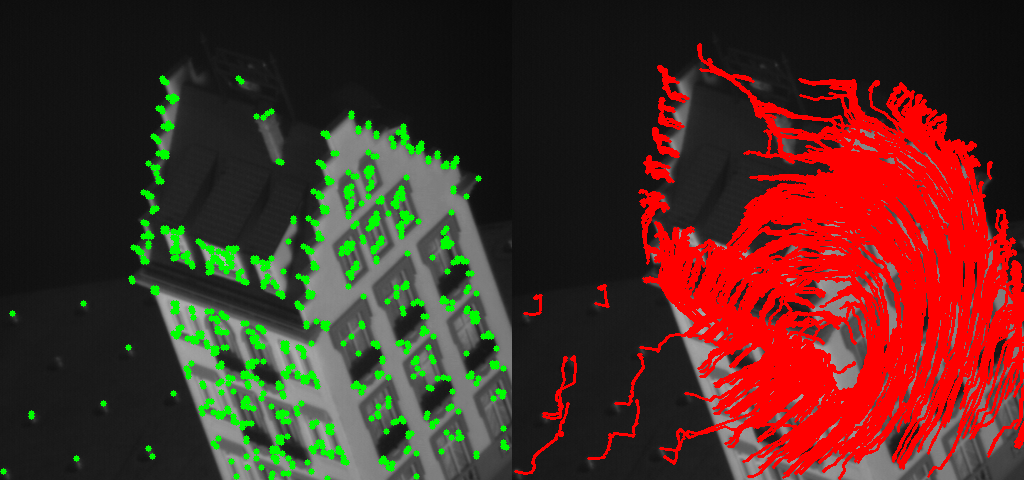


The Progression of Image Coordinates for each of the  20 random keypoints


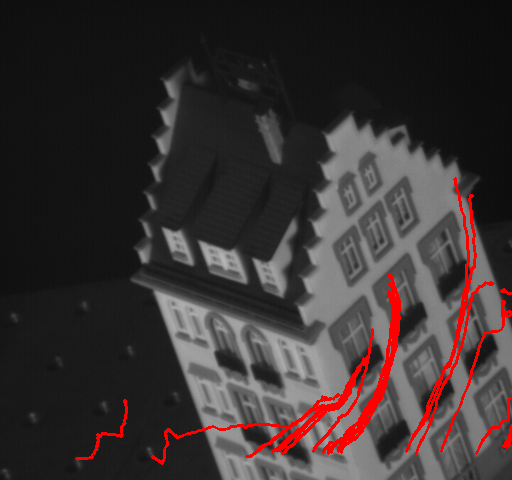


Visualizing the Outliers


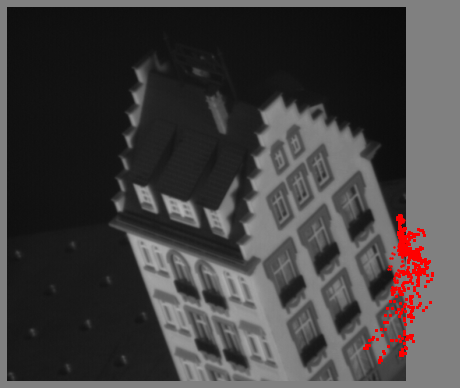

In [5]:
def getNextPoints(x, y, im1, im2, ws):
    '''
    Iterative Lucas-Kanade feature tracking
    x,  y : initialized keypoint position in im2
    ws: patch window size

    output: tracked keypoint positions in im2
    '''
    im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
    x_prime = np.copy(x)
    y_prime = np.copy(y)
    iy, ix = np.gradient(im1)
    hw = int(ws/2)

    for i in range(len(x)):
        Ix = cv2.getRectSubPix(ix, (ws, ws), (x[i], y[i]))
        Iy = cv2.getRectSubPix(iy, (ws, ws), (x[i], y[i]))
        Sx2 = np.sum(Ix**2)
        Sxy = np.sum(Ix * Iy)
        Sy2 = np.sum(Iy**2)

        I_t = cv2.getRectSubPix(im2, (ws, ws), (x_prime[i], y_prime[i])) - cv2.getRectSubPix(im1, (ws, ws), (x[i], y[i]))

        for j in range(5):
            A = np.array([[Sx2, Sxy], 
                          [Sxy, Sy2]])
            b = np.array([(np.sum(Ix * I_t)), (np.sum(Iy * I_t))])

            try:
                d = np.linalg.solve(A, b)
            except np.linalg.LinAlgError:
                pass

            x_prime[i] += d[0]
            y_prime[i] += d[1]
            if x_prime[i] > hw and x_prime[i] < im.shape[1]-hw and y_prime[i] > hw and y_prime[i] < im.shape[0]-hw:
                I_t = cv2.getRectSubPix(im2, (ws, ws), (y_prime[i], y_prime[i])) - cv2.getRectSubPix(im1, (ws, ws), (x[i], y[i]))
                break
            
    return x_prime, y_prime


ws = 15
tracked_pts = trackPoints(pt_x=key_pts[:,0], pt_y=key_pts[:,1], im=im, ws=ws)

#Visualizing the results
print('The Number of Keypoints detected:', key_pts[:,0].shape[0])

#Q1:
result_1 = np.copy(im[0])

for i in range(tracked_pts[:][0].shape[0]):
    for j in range(tracked_pts[:][0][0].shape[0]-1):
        cv2.line(result_1, (int(tracked_pts[:][0][i][j]), int(tracked_pts[:][1][i][j])), (int(tracked_pts[:][0][i][j+1]), int(tracked_pts[:][1][i][j+1])), (0,0,255), 2)
result_1 = np.concatenate((result_keypoints,result_1), axis=1)
cv2_imshow(result_1)

#Q2:
result_2 = np.copy(im[0])
print('\nThe Progression of Image Coordinates for each of the  20 random keypoints')

for i in range(650,670,1):   
    for j in range(tracked_pts[:][0][0].shape[0]-1):
        cv2.line(result_2, (int(tracked_pts[:][0][i][j]), int(tracked_pts[:][1][i][j])), (int(tracked_pts[:][0][i][j+1]), int(tracked_pts[:][1][i][j+1])), (0,0,255), 2)
cv2_imshow(result_2)

#Q3:
print('\nVisualizing the Outliers')
plt.figure(figsize=(8, 8))
result_3 = np.array(im[0], dtype=np.uint8)
plt.gcf().set_facecolor('gray')
plt.axis('off')
plt.imshow(result_3, cmap='gray')

for i in (np.where(tracked_pts[0] > im[0].shape[1]))[0]:
    plt.scatter(tracked_pts[0][i].flatten(), tracked_pts[1][i].flatten(), s=2, c='r')

for j in (np.where(tracked_pts[1] > im[0].shape[0]))[0]:
    plt.scatter(tracked_pts[0][j].flatten(), tracked_pts[1][j].flatten(), s=2, c='r')